# Exercise 3.2

In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
import random
import time

In [ ]:
"""
Simple Simulation of the FrozenLake environment; 
code structure taken from gym documentation. The loop chooses a random action at each time step.
The action is then executed and the environment is rendered. Rendering is delayed by 0.1 seconds after each step,
as otherwise the simulation terminates after <1 second and cannot actually be observed by humans.
"""
env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True, render_mode="human")

observation, info = env.reset()  #obligatory reset

episode_over = False
while not episode_over:
    action = env.action_space.sample()  #sample random action (either 0 or 1, left or right)
    print("action", action)
    observation, reward, terminated, truncated, info = env.step(action)  #action is performed

    print(observation)

    env.render()  #environment is rendered
    time.sleep(2)  #delay

    #if either a termination condition is met or the maximum episode length is reached, the loop needs to end
    episode_over = terminated or truncated

env.close()  #close the environment

#### (a)

Initial policy:
    - RIGHT: 35%
    - DOWN: 35%
    - LEFT: 15%
    - UP: 15%

The idea behind this is that as the goal is on the bottom right and the start is on the top left,
the general trend should be to move to the bottom right of the lake.

In [2]:
class SimplePolicy:
    def __init__(self, gamma=1):
        self.moves = [0, 1, 2, 3]
        self.probabilities = [0.15, 0.35, 0.35, 0.15]
        self.returns =[[] for _ in range(16)]
        self.v = np.zeros(16, dtype=float)
        self.gamma = gamma
    
    def policy(self, observation):
        return np.random.choice(self.moves, p=self.probabilities)
    
    def evaluate(self, path, rewards):
        g = 0
        for t in reversed(range(len(path)-1)):
            g = self.gamma*g + rewards[t]
            if path[t] not in path[:t]:
                self.returns[path[t]].append(g)
                self.v[path[t]] = np.average(self.returns[path[t]])

        return self.v
    
    def get_v(self):
        return self.v

In [3]:
def run_episode(env, policy):
    
    observation, info = env.reset()  #obligatory reset
    path = [observation]
    rewards = []
    
    episode_over = False
    while not episode_over:
        action = policy.policy(observation)
        observation, reward, terminated, truncated, info = env.step(action)  #action is performed
    
        path.append(observation)
        rewards.append(reward)
    
        #if either a termination condition is met or the maximum episode length is reached,
        #the loop needs to end
        episode_over = terminated or truncated
    
    return path, rewards

In [4]:
def run(policy, n=100):
    env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
    
    for _ in range(n):
        path, rewards = run_episode(env, policy)
        policy.evaluate(path, rewards)
    
    return policy.get_v()

In [5]:
policy = SimplePolicy(gamma=1)
value_funct = run(policy, n=1000)

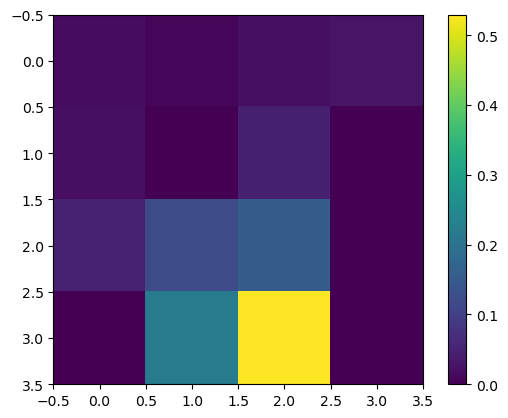

In [6]:
#heatmap = policy_eval(n=1000, gamma=1)
plt.imshow(value_funct.reshape(4,4))
plt.colorbar()
plt.show()
#print(policy_eval(n=100))

Analysis:
    -   A state value is only the average action value in that state across all actions and the policy
    -   However, if the state has an action that guarantees a reward (e.g. the action to the left of the goal, 
        in this case with a value of ~0.5), that fact is not accurately represented by just the state value function
    -   Similarly, states far from the goal are all evaluated very close to each other in value (in this case 0),
        even though some of them are clearly superior (e.g. tile 6 compared to tile 4), but since the agent generally
        fails to retrieve a reward very often, they have almost the same value.

#### (b)

In [7]:
class MCPolicy:
    def __init__(self, gamma=1, epsilon=0.1):
        self.moves = [0, 1, 2, 3]
        self.returns = [[[] for _ in range(4)] for _ in range(16)]
        self.v = np.zeros((16, 4), dtype=float)
        self.gamma = gamma
        self.epsilon = epsilon
    
    def policy(self, observation):
        #implements epsilon-greedy algorithm
        x = np.random.rand()
        if x < self.epsilon:
            t = self.moves
        else:
            t = np.asarray(self.v[observation] == np.max(self.v[observation])).nonzero()[0]
        return np.random.choice(t)
    
    def evaluate(self, path, actions, rewards):
        g = 0
        for t in reversed(range(len(path)-1)):
            g = self.gamma * g + rewards[t]
            if (path[t], actions[t]) not in zip(path[:t], actions[:t]):
                self.returns[path[t]][actions[t]].append(g)
                self.v[path[t]][actions[t]] = np.average(self.returns[path[t]][actions[t]])

        return self.v
    
    def get_v(self):
        return self.v

In [8]:
def run_episode(env, policy):
    observation, info = env.reset()  #obligatory reset
    
    path = [observation]
    rewards = []
    actions = []

    episode_over = False
    while not episode_over:
        action = policy.policy(observation)
        actions.append(action)
        
        observation, reward, terminated, truncated, info = env.step(action)  #action is performed

        path.append(observation)
        rewards.append(reward)

        #if either a termination condition is met or the maximum episode length is reached,
        #the loop needs to end
        episode_over = terminated or truncated

    return path, actions, rewards


In [9]:
def run(policy, n=100):
    env = gym.make('FrozenLake-v1', desc=None, map_name="4x4", is_slippery=True)
    
    rewards_list = []
    for _ in range(n):
        path, actions, rewards = run_episode(env, policy)
        policy.evaluate(path, actions, rewards)
        rewards_list.append(rewards[-1])
    
    return policy.get_v(), rewards_list

In [99]:
policy = MCPolicy(gamma=1)
value_func, rewards_list = run(policy, n=1000)
print(value_func)
print(sum(rewards_list))

[[0.37259101 0.24509804 0.27230047 0.21287129]
 [0.06060606 0.15238095 0.02380952 0.12      ]
 [0.0625     0.16176471 0.04166667 0.05263158]
 [0.         0.         0.09090909 0.10344828]
 [0.39051919 0.24161074 0.24427481 0.27027027]
 [0.         0.         0.         0.        ]
 [0.15384615 0.07142857 0.18518519 0.14285714]
 [0.         0.         0.         0.        ]
 [0.28235294 0.27472527 0.2688172  0.43726236]
 [0.26315789 0.52132701 0.3559322  0.2       ]
 [0.49268293 0.30434783 0.3125     0.25      ]
 [0.         0.         0.         0.        ]
 [0.         0.         0.         0.        ]
 [0.41935484 0.44680851 0.6372315  0.36666667]
 [0.56       0.81102362 0.8        0.75      ]
 [0.         0.         0.         0.        ]]
349.0


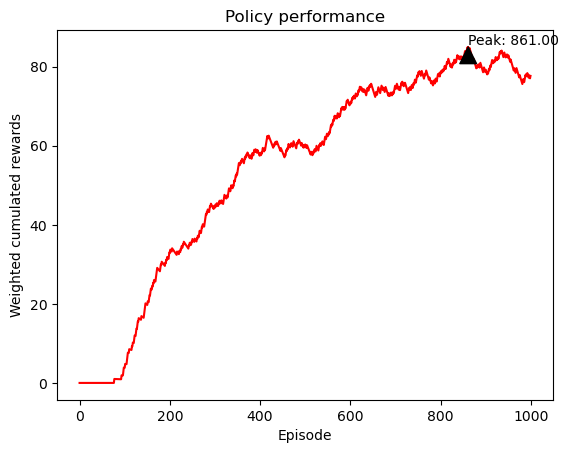

In [100]:
# simple sum over all past rewards; unused
cumulated_rewards_list = list(map(lambda x: sum(rewards_list[:(x+1)]), list(range(len(rewards_list)))))

# each episode's result (reward) is weighted by a decaying factor (form of e^(-x)) based on how far in 
# the past it is. This ensures that recent results are weighted more strongly than those generated by 
# outdated iterations of the policy.
weighted_crl = list(map(
    lambda x: sum(map(
        lambda y: np.e**(-0.005*y)*rewards_list[x-y], 
        list(range(len(rewards_list[:(x+1)]))))), 
    list(range(len(rewards_list)))))

peak_policy = np.argmax(weighted_crl)
peak_performance = weighted_crl[peak_policy]
plt.plot(weighted_crl, color="red")
plt.annotate(f'Peak: {peak_policy:.2f}', xy=(peak_policy, peak_performance), xytext=(peak_policy, peak_performance + 0.5),
             arrowprops=dict(facecolor='black', shrink=0.05))
plt.xlabel('Episode')
plt.ylabel('Weighted cumulated rewards')
plt.title('Policy performance')
plt.show()

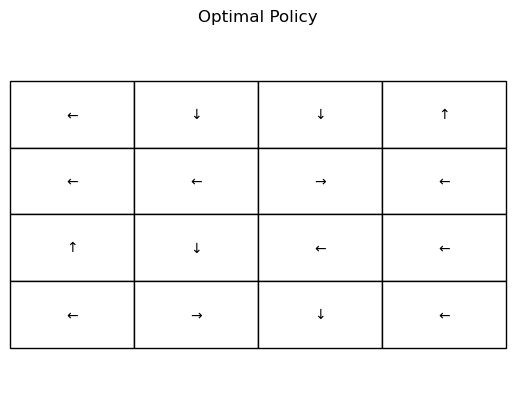

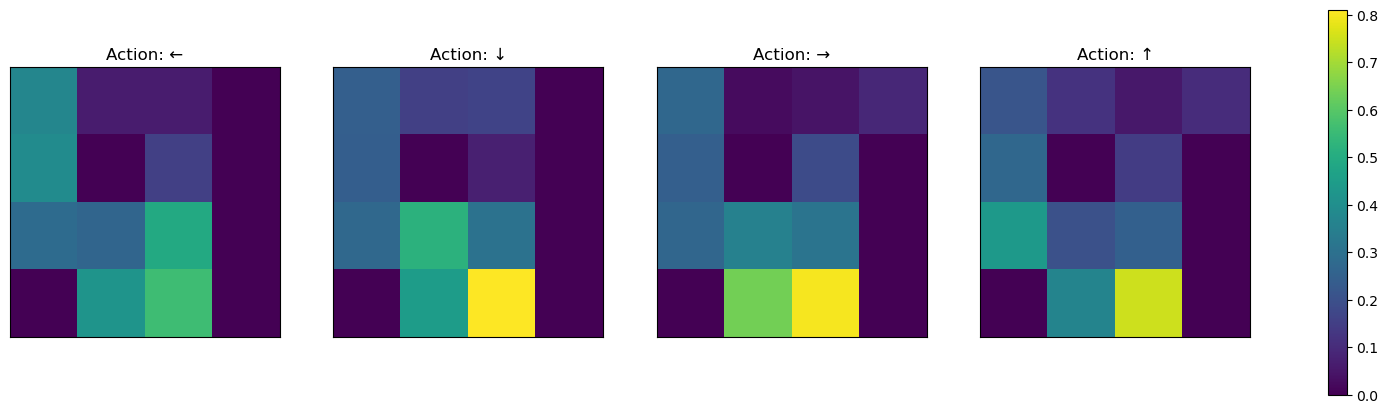

In [101]:
optimal_policy = np.asarray(list(map(np.argmax, value_func))).reshape(4, 4)
actions_labels = ['←', '↓', '→', '↑']
policy_grid = np.array([[actions_labels[action] for action in row] for row in optimal_policy])

fig, ax = plt.subplots()
ax.set_title('Optimal Policy')
ax.axis('off')
table = ax.table(cellText=policy_grid, loc='center', cellLoc='center')
table.scale(1, 4)
plt.show()

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for a in range(4):
    ax = axes[a]
    q_values = value_func[:, a].reshape(4, 4)
    im = ax.imshow(q_values, vmin=np.min(value_func), vmax=np.max(value_func), cmap='viridis')
    ax.set_title("Action: %s" % actions_labels[a])
    ax.set_xticks([]) # remove x-axis ticks
    ax.set_yticks([]) # remove y-axis ticks
fig.colorbar(im, ax=axes.ravel().tolist())
plt.show()

Even though in (3,2), the action RIGHT should give a reward of 1 every time, because it is slippery and there is a randomness factor, its state-action value is less than 1.
Controversely, the action value for the action DOWN is actually sometimes greater than the one for RIGHT. This is because the discounting factor `gamma` is 1 (i.e. there is no discounting), and because when using the action DOWN in (3,2), there is a chance that the agent slips into the goal state, and if not, it either slips into another safe state (there are no adjacent holes) or stays in (3,2).
Therefore, the calculated action values can only be relied upon to a certain extent, as the best action in (3,2) is obviously to move RIGHT, but due to the non-deterministic environment dynamics, this will not always be represented in the state-action values.